# Reversal of the impact chain - glacier example  (part 1 -> create fitted glacier projections relative to GMT)


This notebook creates the following for glaciers in High Mountain Asia (HMA, i.e., RGI13-14-15):
- aggregated glacier volume change model projections in 2100 (% rel. to 2020): 
    - `glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv`
        - `global_temp_ch_2071-2100_preindustrial`: is here the global mean temperature change in °C
        - `rel_ice_%_2020`: is here the regional glacier mass relative to the year 2020 (in %)
- does a LOWESS fit for many percentiles to estimate glacier change projections relative to a given global mean temperature change (GMT):
    - `lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv`
        - `deltaTemp`: is here the global mean temperature change in °C
        - `frac` : the chosen hyperparameter of how much data points are applied for the local regression, here 0.48
        - `q0.01, ...q0.50, ... q0.99`: LOWESS quantile regression estimates of regional glacier mass relative to the year 2020 (in %)
- creates a figure for the methods part of Pfleidere et al., in review
    - `fig6.pdf`, `fig.6.png`

--- 

**Some more details are in Pfleiderer et al. (in review), methods application 3 description and below**
- we use glacier model projections for CMIP5 and CMIP6 GCMs at the year 2100 from in total three glacier models (data from Zekollari et al., in review)
    - the three participated glacier models are the follwing (with links to original submitted projection data)
        - GloGEM : https://zenodo.org/doi/10.5281/zenodo.10908277  (see also original publication: https://doi.org/10.3389/feart.2015.00054)
        - OGGM v161: https://doi.org/10.5281/zenodo.8286065 (see also documentation: https://docs.oggm.org/en/stable/) 
        - PyGEM-OGGM : https://nsidc.org/data/hma2_ggp/versions/1 (see also documentation: https://pygem.readthedocs.io/en/latest/introduction.html) 
    - we weight every glacier model/gcm/scenario combination equally for the fit 
    - OGGM has 109 experiments available, some glacier models have less experiments available than others (PyGEM: 78, GloGEM: 51)
    - here we only do the fit over the three regions RGI13-14-15 together (but it could in theory be repeated for other regions)
- about the LOWESS fits:
    - similarly as done here https://github.com/lilianschuster/glacier-model-projections-until2300
        - LOWESS fits done with the MOEPY package -> https://ayrtonb.github.io/Merit-Order-Effect/ug-08-lowess-quick-start/#quantile
        - we computed percentiles from 1 to 99th percentile in "1%" steps
- global mean warming here defined as done in IPCC AR6 WG1, that means:
    - we assume 0.69°C warming from preindustrial levels (1850-1900) to 1986-2005 for every GCM, then use the warming as given by individual GCMs ... 

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

try:
    from moepy import lowess, eda   # this is the LOWESS fitting library that we use ... 
    import oggm  # only necessary for some additional glacier characteristics 
    import geopandas as gpd
except:
    # if you just want to look into the data, you don't need these packages
    pass 

In [3]:
try:
    import oggm

    df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
    rgidf_l = []
    for r in ['13', '14', '15']: 
        path_rgi = oggm.utils.get_rgi_region_file(r, version='6')
        rgidf = gpd.read_file(path_rgi)
        rgidf_l.append(rgidf)
    rgidf = pd.concat(rgidf_l)
    print('amount of glaciers in High Mountain Asia (HMA, RGI13-14-15):', + len(df_itmix.loc[rgidf.RGIId]) )
    hma_vol = df_itmix.loc[rgidf.RGIId]['vol_itmix_m3'].sum()/1e9
    print('HMA glacier volume at inventory date: ', hma_vol.round(1), 'km³')
    print('HMA volume rel. to global volume at inventory date: ' , (100*hma_vol / (df_itmix['vol_itmix_m3'].sum()/1e9)).round(1), '%')
except:
    # if OGGM is not installed
    pass

amount of glaciers in High Mountain Asia (HMA, RGI13-14-15): 95536
HMA glacier volume at inventory date:  7013.3 km³
HMA volume rel. to global volume at inventory date:  4.4 %


**Aggregate the relevant glacier projection data for High Mountain Asia from Zekollari et al., in review and the respective GMT changes**

In [4]:
######## glacier projections from Zekollari et al. (in review)
# paths in the OGGM cluster where the different data is located, if you directly want to access them without downloading them, 
# go to https://cluster.klima.uni-bremen.de/~lschuster/ or https://cluster.klima.uni-bremen.de/~oggm  and then to the corresponding folders
path_d = {}
## originally comes from  https://doi.org/10.5281/zenodo.8286065
path_d['OGGM']  = '/home/www/oggm/oggm-standard-projections/oggm-standard-projections-csv-files/1.6.1/common_running_2100/volume/'  
## originally comes from https://nsidc.org/data/hma2_ggp/versions/1
path_d['PyGEM-OGGM'] = '/home/www/lschuster/create_csv_files_CMIP_for_Zekollari_et_al_protect/PyGEM-OGGM/'  
## comes from https://zenodo.org/doi/10.5281/zenodo.10908277
path_d['GloGEM'] = '/home/www/lschuster/provide/reversal_impact_chain_glaciers_pfleiderer/GloGEM_Zekollari_et_al_2024/Volume/'  
# however, if you are just interested in the aggregated result you can just use 'glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv' (see below)

In [5]:
load = False
# this aggregates the data (if you are only interested in the results, just open the dataset)
# - sums up the regions RGI13, RGI14 and RGI 15) 
# - creates relative volume projections (% rel. to 2020)
# - only selects the year 2100 
# - creates one csv that includes all glacier models, gcms and scenarios, together with the estimated global mean temperature change for that scenario
if not load: 
    pd_fit_data_all = pd.read_csv(f'glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv', index_col=[0])
else:
    ##### GMT changes for different GCMs of CMIP5 and CMIP6
    # you can directly download dese files from the following urls
    #_file_cmip5 = oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms.csv', reset=True)
    #_file_cmip6 = oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms.csv', reset=True)
    # here we work on the OGGM cluster and don't need to download them... 
    _file_cmip5 = '/home/www/oggm/oggm-standard-projections/analysis_notebooks/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms_ipcc_ar6_def.csv'
    pd_cmip5_temp_ch_2100 = pd.read_csv(_file_cmip5, index_col=0)
    pd_cmip5_temp_ch_2100['cmip'] = 'CMIP5'
    _file_cmip6 = '/home/www/oggm/oggm-standard-projections/analysis_notebooks/Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms_ipcc_ar6_def.csv'

    pd_cmip6_temp_ch_2100 = pd.read_csv(_file_cmip6, index_col=0)
    pd_cmip6_temp_ch_2100['cmip'] = 'CMIP6'

    # change this path to your local path 
    pd_cmip_temp_ch_2100 = pd.concat([pd_cmip6_temp_ch_2100, pd_cmip5_temp_ch_2100])
    # use all scenarios except ssp534-over
    pd_cmip_temp_ch_2100 = pd_cmip_temp_ch_2100.loc[pd_cmip_temp_ch_2100.ssp != 'ssp534-over']

    t_min, t_max = pd_cmip_temp_ch_2100['global_temp_ch_2071-2100_preindustrial'].min(), pd_cmip_temp_ch_2100['global_temp_ch_2071-2100_preindustrial'].max()
    print(t_min, t_max)

    rgi_regs_global = ['global','01', '02', '03', '04', '05', '06', '07',
                       '08', '09', '10', '11', '12', '13', '14', '15',
                       '16', '17', '18', '19', '13-14-15']
    
    end_year = '2100'
    pd_fit_data_reg_l = []
    for jj,_rgi_reg in enumerate(['13-14-15']): 
        _pd_fit_data_l = []
        if _rgi_reg !='global':
            rgi_reg = f'RGI{_rgi_reg}'
        else:
            rgi_reg = _rgi_reg 

        for cmip in ['CMIP5','CMIP6']:
            pd_cmip = pd_cmip_temp_ch_2100.loc[pd_cmip_temp_ch_2100.cmip == cmip]
            # check that there are temperature values in 2300 available ... 
            pd_cmip = pd_cmip.loc[pd_cmip['global_temp_ch_2071-2100_preindustrial'].dropna().index]
            for gcm_scenario in pd_cmip.index:
                for m in path_d.keys():
                    try:
                        _pd_fit_data = pd.DataFrame(columns=['global_temp_ch_2071-2100_preindustrial','region', 'year', 'rel_ice_%_2020'])

                        gcm, scenario = gcm_scenario.split('_')
                        path = path_d[m]
                        gcm_scenario_m = gcm_scenario + '_' + m
                        n = len(gcm_scenario)
                        if _rgi_reg == '13-14-15':
                            df = 0
                            for sub_rgi_reg in ['RGI13','RGI14','RGI15']:
                                if m == 'GloGEM':
                                    idir = path + f'{sub_rgi_reg}/'
                                else:
                                    idir = path + f'{cmip}/{end_year}/{sub_rgi_reg}/'
                                _df = pd.read_csv(idir + f'{scenario}.csv', index_col=0)
                                _df.columns = [g.upper() for g in _df.columns]
                                _df = _df[gcm.upper()]
                                df += _df
                        else:
                            if m == 'GloGEM':
                                idir = path + f'{rgi_reg}/'
                            else:
                                idir = path  + f'{cmip}/{end_year}/{rgi_reg}/'
                            df = pd.read_csv(idir + f'{scenario}.csv', index_col=0).dropna()
                            df.columns = [g.upper() for g in df.columns]
                            df = df[gcm.upper()]

                        df = df.loc[2020:]

                        df_rel = 100*df/df.loc[2020]
                        #df_rel = df_rel.loc[2020]
                        _pd_fit_data.year = df_rel.index.astype(int)
                        _pd_fit_data['rel_ice_%_2020'] = df_rel.values
                        _pd_fit_data['global_temp_ch_2071-2100_preindustrial'] = pd_cmip.loc[gcm_scenario, 'global_temp_ch_2071-2100_preindustrial']
                        _pd_fit_data['region'] = f'{rgi_reg}'
                        _pd_fit_data['model'] = m
                        _pd_fit_data['cmip'] = cmip
                        _pd_fit_data['gcm_scenario'] = gcm_scenario
                        _pd_fit_data_l.append(_pd_fit_data)
                    except:
                        if cmip == 'CMIP5' and m == 'GloGEM':
                            pass
                        else:
                            print(cmip, m, gcm_scenario)
        pd_fit_data_reg = pd.concat(_pd_fit_data_l)
        pd_fit_data_reg = pd_fit_data_reg.reset_index(drop=True)
        pd_fit_data_reg_l.append(pd_fit_data_reg)
    pd_fit_data_all = pd.concat(pd_fit_data_reg_l)
    pd_fit_data_all = pd_fit_data_all.reset_index(drop=True)
    assert np.all(pd_fit_data_all['rel_ice_%_2020']>=0)
    assert np.all(pd_fit_data_all['rel_ice_%_2020']<=300)

    print(pd_fit_data_all['global_temp_ch_2071-2100_preindustrial'].min(), pd_fit_data_all['global_temp_ch_2071-2100_preindustrial'].max())
    print(pd_fit_data_all['model'].unique())
    print(pd_fit_data_all['rel_ice_%_2020'].min(), pd_fit_data_all['rel_ice_%_2020'].max())
    print(pd_fit_data_all['year'].min(), pd_fit_data_all['year'].max())
    # actually we are only interested in the 2100 values ... 
    pd_fit_data_all = pd_fit_data_all.loc[pd_fit_data_all.year == 2100]
    pd_fit_data_all.to_csv(f'glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv')


In [6]:
# check that we have the correct region and year
assert np.all(pd_fit_data_all.region == 'RGI13-14-15')
assert np.all(pd_fit_data_all.year == 2100)
pd_raw_data_sel = pd_fit_data_all.copy()

In [7]:
try:
    # estimate the available and the used scenarios with GMT estimates
    def unique_items(list1, list2):
        unique_in_list1 = set(list1) - set(list2)
        unique_in_list2 = set(list2) - set(list1)
        return list(unique_in_list1), list(unique_in_list2)

    m = 'GloGEM'
    cmip = 'CMIP6'

    for m in ['OGGM', 'GloGEM', 'PyGEM-OGGM']:
        for cmip in ['CMIP5','CMIP6']:
            if cmip == 'CMIP5':
                scenarios = ['rcp26', 'rcp45','rcp85']
                if m == 'OGGM':
                    scenarios = scenarios + ['rcp60']
            else:
                scenarios = ['ssp119', 'ssp126','ssp245','ssp370','ssp585']
                if m == 'OGGM':
                    scenarios = scenarios + ['ssp434','ssp460']
            if cmip == 'CMIP5' and m=='GloGEM':
                pass
            else:
                gcm_scenarios = []

                path = path_d[m]

                for scenario in scenarios:
                    sub_rgi_reg = 'RGI13'
                    if m == 'GloGEM':
                        idir = path + f'{sub_rgi_reg}/'
                    else:
                        idir = path + f'{cmip}/2100/{sub_rgi_reg}/'

                    _df = pd.read_csv(idir + f'{scenario}.csv', index_col=0).dropna(axis=1)
                    for c in _df.columns:
                        gcm_scenarios.append(c +'_' +  scenario)
                used_gcm_scenarios = _pd_sel.loc[(_pd_sel.cmip==cmip) & (_pd_sel.model==m)].gcm_scenario.values
                unique_list1, unique_list2 = unique_items(gcm_scenarios, used_gcm_scenarios)
                
                
                # gcm-scenario combinations that are in the original publication but where we did not have GMT estimates available are given in the "unique_list"
                print(m, cmip, 'available projections with scenarios/GCMs=',len(gcm_scenarios),
                      ', used scenarios/GCMs (those with GMT estimates)=', len(used_gcm_scenarios), unique_list1, unique_list2)
except:
    print('individual csv files have not been prescribed, but not necessary for the next steps')
# amount of experiments per model that will participate in the fit
pd_raw_data_sel.groupby('model').count()['gcm_scenario']

individual csv files have not been prescribed, but not necessary for the next steps


model
GloGEM         51
OGGM          109
PyGEM-OGGM     78
Name: gcm_scenario, dtype: int64

In [8]:
pd_raw_data_sel

,global_temp_ch_2071-2100_preindustrial,region,year,rel_ice_%_2020,model,cmip,gcm_scenario
80,2.320556,RGI13-14-15,2100,46.198954,OGGM,CMIP5,CCSM4_rcp45
161,2.320556,RGI13-14-15,2100,49.737172,PyGEM-OGGM,CMIP5,CCSM4_rcp45
243,2.290734,RGI13-14-15,2100,36.982038,OGGM,CMIP5,MPI-ESM-LR_rcp45
324,2.290734,RGI13-14-15,2100,43.305751,PyGEM-OGGM,CMIP5,MPI-ESM-LR_rcp45
406,2.544987,RGI13-14-15,2100,37.980942,OGGM,CMIP5,CNRM-CM5_rcp45
...,...,...,...,...,...,...,...
19030,1.711997,RGI13-14-15,2100,57.433570,PyGEM-OGGM,CMIP6,EC-EARTH3-VEG_ssp119
19112,1.711997,RGI13-14-15,2100,52.614488,GloGEM,CMIP6,EC-EARTH3-VEG_ssp119
19193,1.135359,RGI13-14-15,2100,73.334407,OGGM,CMIP6,CAMS-CSM1-0_ssp119
19274,2.609334,RGI13-14-15,2100,34.833741,OGGM,CMIP6,MRI-ESM2-0_ssp434


Text(0, 0.5, 'Glacier mass in High-Mountain Asia (%, rel. to 2020)')

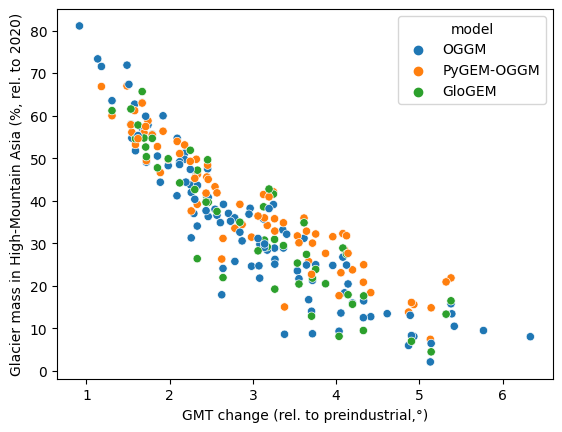

In [9]:
# quick check
sns.scatterplot(data=pd_raw_data_sel, x= 'global_temp_ch_2071-2100_preindustrial', y='rel_ice_%_2020', hue='model')
plt.xlabel('GMT change (rel. to preindustrial,°)')
plt.ylabel('Glacier mass in High-Mountain Asia (%, rel. to 2020)')

**Do the LOWESS fit with the moepy package**

In [10]:
pd_fit_data_all = pd.read_csv(f'glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv', index_col=0)
# we use two iterations to remove potential outliers (as a compromise between a robust fit but still sufficiently fast computational time)
it = 2
#_rgi_reg = rgi_regs_global[r]
_rgi_reg = '13-14-15'  #'global',
sim_year = 2100
N = 2000

if _rgi_reg !='global':
    region = f'RGI{_rgi_reg}'
else:
    region = _rgi_reg 
    
# Format the percentile string with leading zeros
quantiles_str = []
quantiles = np.arange(0.01,1,0.01)
for i in quantiles:
    _str = f'q{i:0.2f}' #.format(i)  
    quantiles_str.append(_str)
    
run_lowess_fit = False
if run_lowess_fit: 
    # the lowess fit takes some time, specifically, if we use it=2
    r_pd_fit_stats = pd.DataFrame(columns=['region','year', 'fit_opt' ,'deltaTemp', 'frac','it','N'], 
                                  index = np.arange(0,400000,1))

    # this is the data we want to fit
    data = pd_fit_data_all.loc[(pd_fit_data_all.year==sim_year) & (pd_fit_data_all.region==region)]
    x = data['global_temp_ch_2071-2100_preindustrial'].values
    y = data['rel_ice_%_2020'].values

    eval_x =np.arange(x.min().round(1), x.max()*1.001, 0.05)
    # just for comparison, also compute the exponential fit -> decided to not use the exponential fit as LOWESS worked better
    #r_pd_fit_stats.loc[:len(eval_x)-1,'deltaTemp'] = eval_x
    #popt, pcov = curve_fit(exponential_decay, x,y,
    #                   loss='soft_l1', f_scale=0.1, bounds = param_bounds) 
    #a_opt, b_opt = popt
    #y_fitted_exp = exponential_decay(eval_x, a_opt, b_opt)
    #r_pd_fit_stats.loc[:len(eval_x)-1,'fit_opt'] = 'exp'
    #r_pd_fit_stats.loc[:len(eval_x)-1, 'q50'] = y_fitted_exp

    jj = 0
    # when using it=1, and a larger frac range, the best frac was 0.48
    # -> let's search just around there with it=2
    for _,frac in enumerate(np.arange(0.46, 0.51,
                                      0.01)):
        # Compute the median, and a lot of quantiles 
        ind_start = (len(eval_x)-1) + (len(eval_x)-1)*jj
        ind_end = ind_start + len(eval_x)-1
        r_pd_fit_stats.loc[ind_start:ind_end,'deltaTemp'] = eval_x
        df_quantiles = lowess.quantile_model(x, y, x_pred=eval_x, frac=frac, num_fits=N, robust_iters=it,
                             qs=quantiles)
        r_pd_fit_stats.loc[ind_start:ind_end,'deltaTemp'] = eval_x
        
        j= 0
        # compute some statistics (do the quantiles go below zero, are they monotonoically decreasing???)
        for s,q in zip(quantiles_str, quantiles):
            r_pd_fit_stats.loc[ind_start:ind_end,s] = df_quantiles[q].values
            r_pd_fit_stats.loc[ind_start:ind_end,f'min_{s}_diff'] = (df_quantiles[q].iloc[:-1].values - df_quantiles[q].iloc[1:].values).min()
            r_pd_fit_stats.loc[ind_start:ind_end,f'min_{s}'] = df_quantiles[q].min()
            j+=1

        r_pd_fit_stats.loc[ind_start:ind_end,'frac'] = frac
        r_pd_fit_stats.loc[ind_start:ind_end,'it'] = it
        r_pd_fit_stats.loc[ind_start:ind_end,'N'] = N
        r_pd_fit_stats.loc[ind_start:ind_end,'fit_opt'] = 'lowess_predi'
        jj += 1
        print(frac)


    r_pd_fit_stats = r_pd_fit_stats.dropna(how='all')
    r_pd_fit_stats['region'] = region
    r_pd_fit_stats['year'] = sim_year
    r_pd_fit_stats[r_pd_fit_stats.columns[3:]] = r_pd_fit_stats[r_pd_fit_stats.columns[3:]].astype(float)
    
    #r_pd_fit_stats.to_csv(f'fit_stats_v2024-03-27_predi_{region}_{sim_year}_{it}_{N}_OGGM_PyGEM_GloGEM.csv')
    #r_pd_fit_stats = pd.read_csv(f'fit_stats_v2024-03-27_predi_{region}_{sim_year}_{it}_{N}_OGGM_PyGEM_GloGEM.csv', index_col=[0])
    
    # this should be true at least for the median fit .. .
    q = 'q0.50'
    _r_pd_fit_stats_sel = r_pd_fit_stats.loc[r_pd_fit_stats[f'min_{q}']>=0]
    _r_pd_fit_stats_sel = _r_pd_fit_stats_sel.loc[_r_pd_fit_stats_sel[f'min_{q}_diff']>=0]

    for q in quantiles_str: 
        _r_pd_fit_stats_sel = _r_pd_fit_stats_sel.loc[_r_pd_fit_stats_sel[f'min_{q}']>=-1]

    ### now select the fit that is never increasing with GMT increase and that is never negative
    # this should be true at least for the median fit .. .
    q = 'q0.50'
    _r_pd_fit_stats_sel = r_pd_fit_stats.loc[r_pd_fit_stats[f'min_{q}']>=0]
    _r_pd_fit_stats_sel = _r_pd_fit_stats_sel.loc[_r_pd_fit_stats_sel[f'min_{q}_diff']>=0]
    
    # for the quantiles, we have to be a bit less strict -> for actual fitted "projections", we can then correct for that again. 
    for q in quantiles_str: 
        _r_pd_fit_stats_sel = _r_pd_fit_stats_sel.loc[_r_pd_fit_stats_sel[f'min_{q}']>=-0.58]
    
    r_pd_fit_stats_sel = _r_pd_fit_stats_sel.copy() 
    for q in quantiles_str:
        r_pd_fit_stats_sel = r_pd_fit_stats_sel.loc[r_pd_fit_stats_sel[f'min_{q}_diff']>=0]
    if len(r_pd_fit_stats_sel)==0:
        print('try with q0.02 to q0.98')
        r_pd_fit_stats_sel = _r_pd_fit_stats_sel.copy() 
        for q in quantiles_str[1:-1]:
            r_pd_fit_stats_sel = r_pd_fit_stats_sel.loc[r_pd_fit_stats_sel[f'min_{q}_diff']>=0]
    if len(r_pd_fit_stats_sel)==0:
        r_pd_fit_stats_sel = _r_pd_fit_stats_sel.copy() 
        print('try with q0.03 to q0.97')
        for q in quantiles_str[2:-2]:
            r_pd_fit_stats_sel = r_pd_fit_stats_sel.loc[r_pd_fit_stats_sel[f'min_{q}_diff']>=0]
    if len(r_pd_fit_stats_sel)==0:
        r_pd_fit_stats_sel = _r_pd_fit_stats_sel.copy() 
        print('try with q0.05 to q0.95')
        for q in quantiles_str[4:95]:
            r_pd_fit_stats_sel = r_pd_fit_stats_sel.loc[r_pd_fit_stats_sel[f'min_{q}_diff']>=0]

    # save the best "frac"-parameter fit....
    r_pd_fit_stats_sel[['deltaTemp','region','frac','year'] + quantiles_str].to_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv')
# load the dataset
pd_fit = pd.read_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv', index_col=[0])


In [11]:
pd_fit

,deltaTemp,region,frac,year,q0.01,q0.02,q0.03,q0.04,q0.05,q0.06,...,q0.90,q0.91,q0.92,q0.93,q0.94,q0.95,q0.96,q0.97,q0.98,q0.99
432,0.90,RGI13-14-15,0.49,2100,65.842893,68.610010,70.808477,70.725605,70.654863,70.449500,...,79.461386,79.899307,79.955072,80.417668,80.742822,80.638103,82.452998,81.878679,84.626374,83.628921
433,0.95,RGI13-14-15,0.49,2100,64.587215,67.113205,69.373656,69.369143,69.331823,69.149298,...,78.415239,78.837885,78.919148,79.330434,79.650020,79.613370,81.320675,80.862661,83.513969,82.875533
434,1.00,RGI13-14-15,0.49,2100,63.316019,65.626162,67.933889,68.008773,68.005848,67.848656,...,77.373062,77.781292,77.886155,78.249826,78.564057,78.593691,80.198036,79.846215,82.399678,82.109564
435,1.05,RGI13-14-15,0.49,2100,62.009069,64.150512,66.480996,66.640652,66.676366,66.547412,...,76.334594,76.728268,76.854892,77.174542,77.483948,77.578143,79.085000,78.830561,81.285065,81.329867
436,1.10,RGI13-14-15,0.49,2100,60.652241,62.688755,65.008954,65.259337,65.342534,65.244862,...,75.299171,75.677328,75.824314,76.103644,76.408402,76.565546,77.980531,77.816710,80.170749,80.535777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,6.05,RGI13-14-15,0.49,2100,1.582864,0.680004,1.217916,2.656689,1.653587,1.726286,...,11.665097,15.353260,16.285867,16.759004,16.534439,16.197532,17.805607,17.211556,18.622369,20.727372
536,6.10,RGI13-14-15,0.49,2100,1.641670,0.659548,1.108332,2.591917,1.476406,1.563816,...,11.204097,14.974064,15.919834,16.392964,16.162503,15.782204,17.466016,16.803342,18.270625,20.448506
537,6.15,RGI13-14-15,0.49,2100,1.705636,0.644157,1.008799,2.533382,1.295021,1.401607,...,10.741264,14.602290,15.555252,16.029780,15.790336,15.365824,17.128426,16.389986,17.936114,20.156131
538,6.20,RGI13-14-15,0.49,2100,1.774242,0.633187,0.920824,2.480365,1.108936,1.238750,...,10.277930,14.238052,15.192554,15.669445,15.418542,14.948164,16.791862,15.972144,17.617258,19.848260


**Create the figure 6**

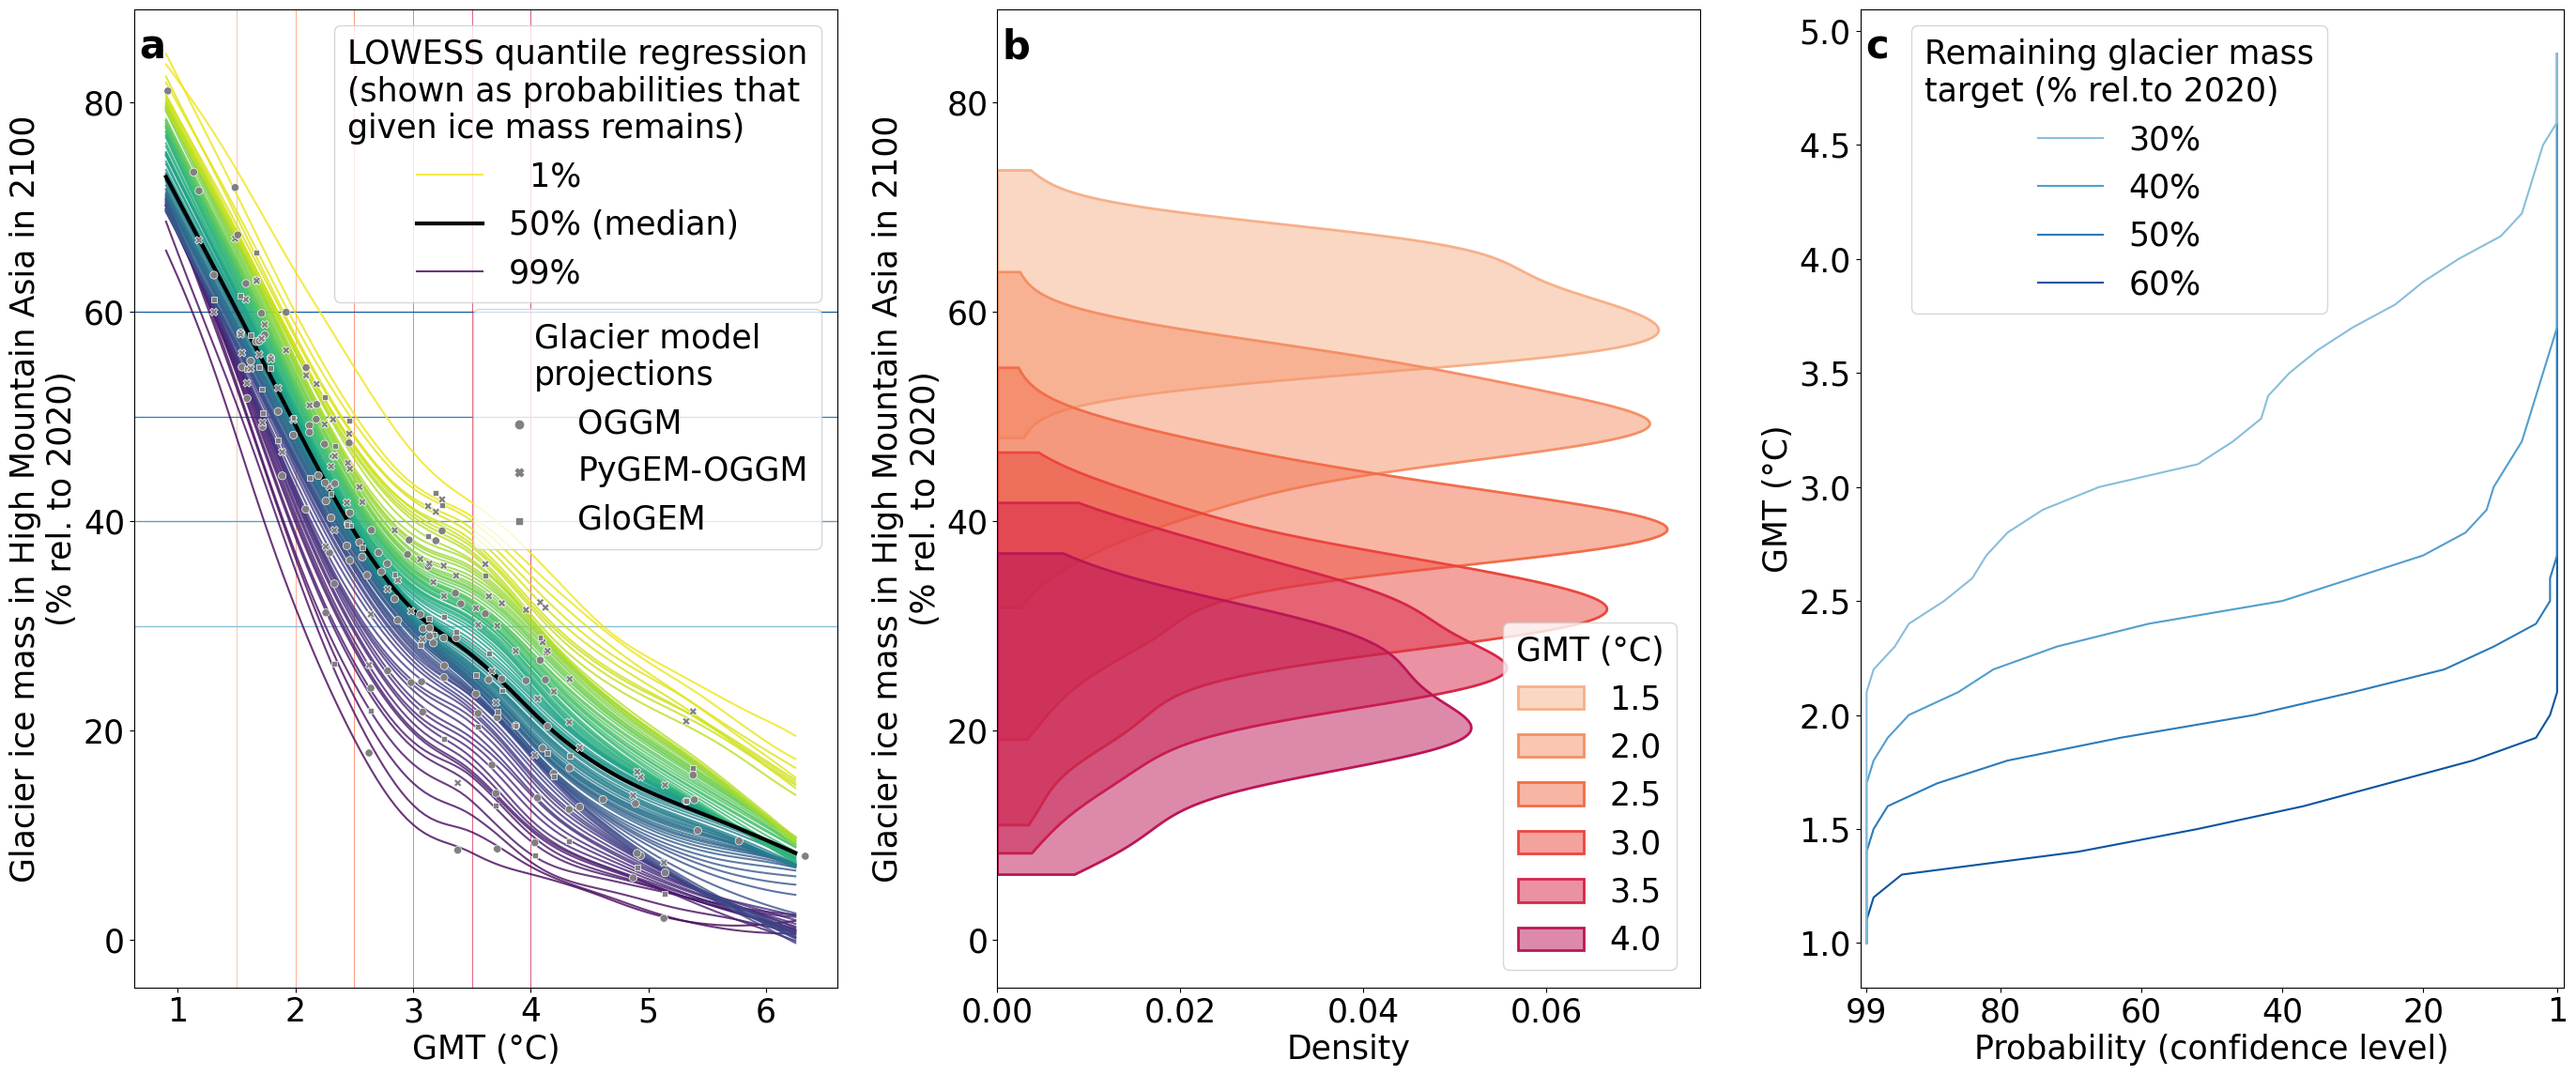

In [9]:
plt.rc('font', size=25)

pd_raw_data_sel = pd.read_csv('glacier_model_proj_from_GCMs_until_2100_test_RGI13-14-15_2100_v2024-03-26_OGGM_PyGEM_GloGEM.csv', index_col=[0])
pd_fit = pd.read_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv', index_col=[0])
quantiles_str = []
quantiles = np.arange(0.01,1,0.01)
for i in quantiles:
    _str = f'q{i:0.2f}'  # Format the percentile string with leading zeros
    quantiles_str.append(_str)
    
    
    
pd_fit.index = pd_fit.deltaTemp.values.round(2)

pd_fit_v = pd_fit[quantiles_str].T
pd_fit_v['q'] = quantiles

_pd_fit_v = pd_fit_v.copy()
_pd_fit_v.index = np.arange(0.01, 1,0.01)

assert len(pd_fit.frac.unique())==1
frac = pd_fit.frac.unique()[0].round(2)
colors = sns.color_palette('viridis', n_colors=100)
colors_2 = sns.color_palette('rocket_r', n_colors=12)
plt.figure(figsize=(28,12))
plt.subplot(131)


for c,q in zip(colors,quantiles_str): 
    if q == 'q0.50':
        sns.lineplot(data=pd_fit, x='deltaTemp', y=q, color='black', label=q, lw=3, zorder=6)
    else:
        sns.lineplot(data=pd_fit, x='deltaTemp', y=q, color=c, label=q, alpha = 0.8, zorder=5)
ax = plt.gca()
num_text_x = 0.007
num_text_y = 0.95
ax.text(num_text_x, num_text_y,
                 'a', fontsize=30, transform=ax.transAxes, weight='bold')
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
assert labels[0] == 'q0.01'
leg = ax.legend([handles[-1],handles[49], handles[0]], 
                ['  1%', '50% (median)', '99%'], 
                #[labels[0],labels[49], labels[-1]], 
                title=f'LOWESS quantile regression\n(shown as probabilities that\ngiven ice mass remains)')
plt.ylabel('Glacier ice mass in High Mountain Asia in 2100\n(% rel. to 2020)')
plt.xlabel('GMT (°C)') # Global mean temperature relative to preindustrial 

_pd_sel = pd_raw_data_sel.loc[pd_raw_data_sel.region == 'RGI13-14-15']
_pd_sel = _pd_sel.loc[_pd_sel.year == 2100]
sns.scatterplot(data= _pd_sel, x= 'global_temp_ch_2071-2100_preindustrial', y='rel_ice_%_2020', style='model', zorder=15, color='grey')
handles, labels = ax.get_legend_handles_labels()
for h in handles[-3:]:
    h.set_color('grey')
ax.get_legend().remove()
leg2 = ax.legend(handles[-3:], labels[-3:], loc = 'upper right', title = 'Glacier model\nprojections',
                 bbox_to_anchor=(1,0.71))
ax.add_artist(leg)
for j,t in enumerate(np.arange(1.5,4.5,0.5)):
    plt.axvline(t, lw=0.5,  color=colors_2[1:-4][j])
ylim = ax.get_ylim()

palette= list(sns.color_palette('Blues'))
j = 0
for perc,c in zip([30,40,50,60],palette[2:]): 
    plt.axhline(perc, lw=1-j*0.05,  color=c)
    j+=1

    
    
plt.subplot(132)
ax = plt.gca()
num_text_x = 0.007
num_text_y = 0.95
ax.text(num_text_x, num_text_y,
                 'b', fontsize=30, transform=ax.transAxes, weight='bold')
bw = 1
for j, t in enumerate(np.arange(1.5,4.5,0.5)):
    sns.kdeplot(data=pd_fit_v[t], y= pd_fit_v[t],
                color=colors_2[1:-4][j], legend=True, cut=0,
               fill=True, alpha=0.5,lw=2, bw_adjust=bw,
               common_norm=True, label=f'{t}')
plt.legend() 

plt.ylabel('Glacier ice mass in High Mountain Asia in 2100\n(% rel. to 2020)')


leg = ax.get_legend()
leg.set_bbox_to_anchor((0.99,0.39))
leg.set_title('GMT (°C)')
ax.set_ylim(ylim)
#####################################################

plt.subplot(133)
# store pd_fit in an xarray
quantiles = xr.DataArray(pd_fit_v.T.values[:-1], dims=['gmt','q'],
                         coords=dict(gmt=pd_fit_v.columns.values[:-1], q=[float(s[1:]) for s in pd_fit_v.index.values]))

def prob_greater_at_gmt(g, thresh):
    '''
    returns the probability of keeping the threshold amount of glacier at given GMT g
    '''
    y = quantiles.sel(gmt=g, method='nearest')
    return 1 - quantiles.q.values[np.abs(y - thresh).argmin()]

gmt_axis = np.arange(1,5,0.1)
j = 0 
for perc,c in zip([30,40,50,60],palette[2:]): 
    p = np.array([prob_greater_at_gmt(g, perc) for g in gmt_axis])
    plt.plot(p*100, gmt_axis, '-', color=c, label = f'{perc}%', zorder=10-j)
    plt.ylabel('GMT (°C)')
    plt.xlabel('Probability (confidence level)')
    plt.tight_layout()
    j +=1
plt.xlim([0.1,99.9])
plt.xticks(ticks = [1,20,40,60,80,99], labels= [1,20,40,60,80,99])
plt.gca().invert_xaxis()
plt.legend(title='Remaining glacier mass\ntarget (% rel.to 2020)', loc = 'upper left', bbox_to_anchor=(0.05,1))

ax = plt.gca()
num_text_x = 0.007
num_text_y = 0.95
ax.text(num_text_x, num_text_y,
                 'c', fontsize=30, transform=ax.transAxes, weight='bold')

#############################################
plt.tight_layout()
plt.savefig('fig6.png', dpi=100)
plt.savefig('fig6.pdf', dpi=200)
